In [1]:
from tensorflow.keras.models import load_model
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae_model import vae_model
#from src.lstm_mapper_model import lstm_mapper_model
from src.util import (
    seq_data, 
    load_sim_data, 
    seq_data, 
    compute_perm_deviation, 
    calculate_perm_error, 
    select_random_instances,
    plot_boxplot,
    mesh_plot_comparisons,
    plot_mesh_permarray,
    load_exp_data,
    plot_mesh
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2025-01-13 10:34:49.978401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736764490.380827  651466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736764490.449674  651466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 10:34:51.179227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1736764517.339793  651466 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

## Load Data

In [4]:
n_el = 32
from pyeit import mesh
mesh_obj = mesh.create(n_el, h0=0.05)

In [17]:
def create_anomaly(ms, x, y, r):
    
    anomaly = [PyEITAnomaly_Circle(center=[x, y], r=r, perm=0.9)]
    ms = mesh.set_perm(ms, anomaly=anomaly, background=0.1)
    return ms

def load_and_concatenate_data(folder_paths, seq_data_function, n_seg=4):

    all_voltage_seq = []
    all_gamma_seq = []

    for folder in folder_paths:
        voltage_exp, _, _, position = load_exp_data(folder)

        center_offset = position[0]
        position_centered = position - center_offset
        tank_radius = 97
        position_scaled_centered = position_centered / tank_radius
        voltage_exp = np.abs(voltage_exp)
        
        
        gamma_exp = []
        for pos in position_scaled_centered[1:]:
            x, y = pos
            ms = create_anomaly(mesh_obj, x, y, 0.2)
            gamma_exp.append(ms.perm_array)

        gamma_exp = np.array(gamma_exp)

        voltage_exp = (voltage_exp - np.mean(voltage_exp, axis=0)) / np.std(voltage_exp, axis=0)
        voltage_exp = np.mean(voltage_exp, axis=1)
        voltage_exp = voltage_exp.reshape(1001, -1)
        voltage_exp = voltage_exp.reshape(-1, 32, 32, 1)
        gamma_exp = gamma_exp.reshape(-1, 2840, 1)

        voltage_seq, gamma_seq = seq_data_function(voltage_exp[1:], gamma_exp, n_seg=n_seg)

        all_voltage_seq.append(voltage_seq)
        all_gamma_seq.append(gamma_seq)

    concatenated_voltage_seq = np.concatenate(all_voltage_seq, axis=0)
    concatenated_gamma_seq = np.concatenate(all_gamma_seq, axis=0)

    return concatenated_voltage_seq, concatenated_gamma_seq

folder_paths = ["exp_data", "exp_data5"]
voltage_seq, gamma_seq = load_and_concatenate_data(folder_paths, seq_data, n_seg=4)

print("Concatenated Voltages Shape:", voltage_seq.shape)
print("Concatenated Permittivity Shape:", gamma_seq.shape)


Concatenated Voltages Shape: (1992, 4, 32, 32, 1)
Concatenated Permittivity Shape: (1992, 2840, 1)


## Loading VAE Model and generating labels

In [19]:
vae = vae_model()  
vae.build(input_shape=(None, 2840)) 
vae.load_weights("weights/vae2D_best_6000.weights.h5")
print("Gewichte erfolgreich geladen.")

_, _, latent_rep = vae.encoder.predict(gamma_seq)

Gewichte erfolgreich geladen.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


## LSTM Mapper Training

In [20]:
(
    v_train_seq,
    v_test_seq,
    gamma_train,
    gamma_test,
    z_train,
    z_test,
) = train_test_split(
    voltage_seq,
    gamma_seq,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [28]:
lstm_mapper = load_model("saved_model/lstm_best_2Dmapper_model.keras")
lstm_mapper.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 4, 30, 30, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 1800)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4, 128)         │       230,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4, 224)         │        28,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4, 128)         │       180,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,714 (4.02 MB)

 Trainable params: 527,356 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 527,358 (2.01 MB)

In [29]:
history_mapper = lstm_mapper.fit(v_train_seq, z_train, epochs=30, batch_size = 8, validation_split = 0.1)

Epoch 1/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.6184 - mse: 0.6184 - val_loss: 0.2121 - val_mse: 0.2121
Epoch 2/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1962 - mse: 0.1962 - val_loss: 0.2048 - val_mse: 0.2048
Epoch 3/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1797 - mse: 0.1797 - val_loss: 0.1825 - val_mse: 0.1825
Epoch 4/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1542 - mse: 0.1542 - val_loss: 0.1758 - val_mse: 0.1758
Epoch 5/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1517 - mse: 0.1517 - val_loss: 0.1649 - val_mse: 0.1649
Epoch 6/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1528 - mse: 0.1528 - val_loss: 0.1561 - val_mse: 0.1561
Epoch 7/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1370 - mse: 0.1370 - val_loss: 0.1574 - val_mse: 0.1574
Epoch 8/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1378 - mse: 0.1378 - val_loss: 0.1520 - val_mse: 0.1520
Epoch 9/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/

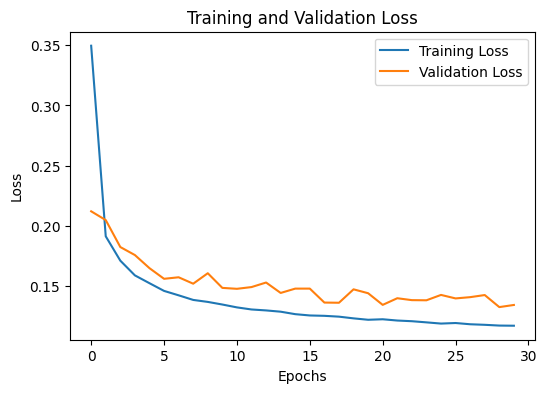

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [31]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "lstm_circle_interpolation.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

Gewichte gespeichert unter: weights/lstm_circle_interpolation.weights.h5


In [32]:
lstm_mapper.load_weights("weights/lstm_circle_interpolation.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [33]:
_, _, pred_latent = vae.encoder.predict(gamma_test)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)

pred_latent.shape, v_test_seq.shape, gamma_pred.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


((200, 8), (200, 4, 32, 32, 1), (200, 2840))

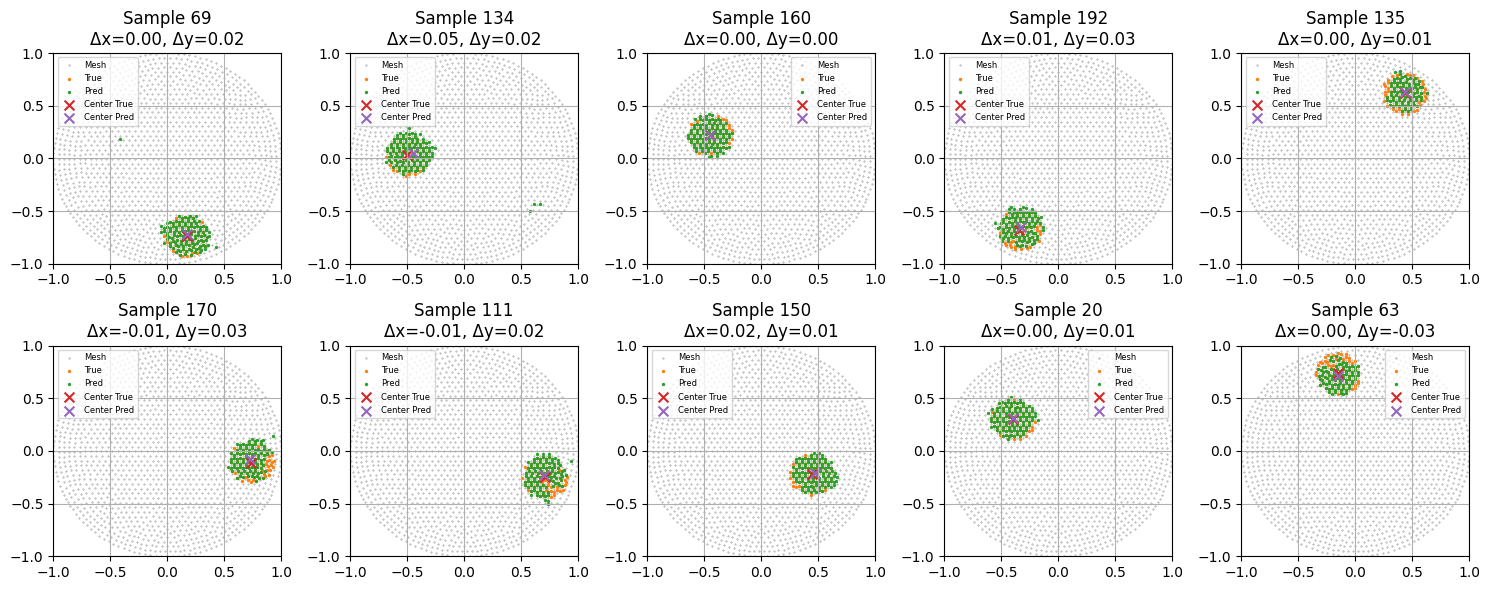

In [34]:
def compute_deviation(mesh_obj, true_perm, predicted_perm, threshhold=0.5):
    pts = mesh_obj.element
    tri = mesh_obj.node

    tri_centers = np.mean(tri[pts], axis=1)

    ixds_true = np.array(np.where(true_perm > threshhold)[0])
    koords_true = tri_centers[ixds_true]
    x_true = np.round(np.mean(koords_true[:, 0]), 2)
    y_true = np.round(np.mean(koords_true[:, 1]), 2)

    ixds_pred = np.array(np.where(predicted_perm > threshhold)[0])
    koords_pred = tri_centers[ixds_pred]
    x_pred = np.round(np.mean(koords_pred[:, 0]), 2)
    y_pred = np.round(np.mean(koords_pred[:, 1]), 2)

    deviation = (x_pred - x_true, y_pred - y_true)

    return deviation, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred

def plot_random_deviations(mesh_obj, true_perms, predicted_perms, num_samples=10, threshhold=0.5):
   
    random_indices = np.random.choice(len(true_perms), size=num_samples, replace=False)

    cols = 5
    rows = int(np.ceil(num_samples / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        ax = axes[i]
        true_perm = true_perms[idx]
        predicted_perm = predicted_perms[idx]

        _, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred = compute_deviation(
            mesh_obj, true_perm, predicted_perm, threshhold=threshhold
        )
        
        ax.grid()
        ax.set_xlim((-1, 1))
        ax.set_ylim((-1, 1))
        ax.scatter(mesh_obj.node[:, 0], mesh_obj.node[:, 1], color="grey", s=0.1, label="Mesh")
        ax.scatter(koords_true[:, 0], koords_true[:, 1], color="C1", s=2, label="True")
        ax.scatter(koords_pred[:, 0], koords_pred[:, 1], color="C2", s=2, label="Pred")
        ax.scatter(x_true, y_true, marker="x", color="C3", s=50, label="Center True")
        ax.scatter(x_pred, y_pred, marker="x", color="C4", s=50, label="Center Pred")
        ax.set_title(f"Sample {idx}\nΔx={x_pred-x_true:.2f}, Δy={y_pred-y_true:.2f}")
        ax.legend(fontsize=6)


    plt.tight_layout()
    plt.show()

plot_random_deviations(mesh_obj, gamma_test, gamma_pred, num_samples=10, threshhold=0.5)

## Load Test-Data

In [36]:
voltage_test_sim, gamma_test_sim , _ = load_sim_data("data1")
voltage_test_normalized = (voltage_test_sim - np.mean(voltage_test_sim, axis=0)) / np.std(voltage_test_sim, axis=0)
voltage_test = voltage_test_normalized.reshape(-1, 32, 32, 1)  
gamma_test = gamma_test_sim.reshape(-1, 2840, 1)

In [37]:
voltage_test_seq, gamma_test_seq = seq_data(voltage_test, gamma_test, n_seg=4)
voltage_test_seq.shape, gamma_test_seq.shape

((996, 4, 32, 32, 1), (996, 2840, 1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/jy2353/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jy2353/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


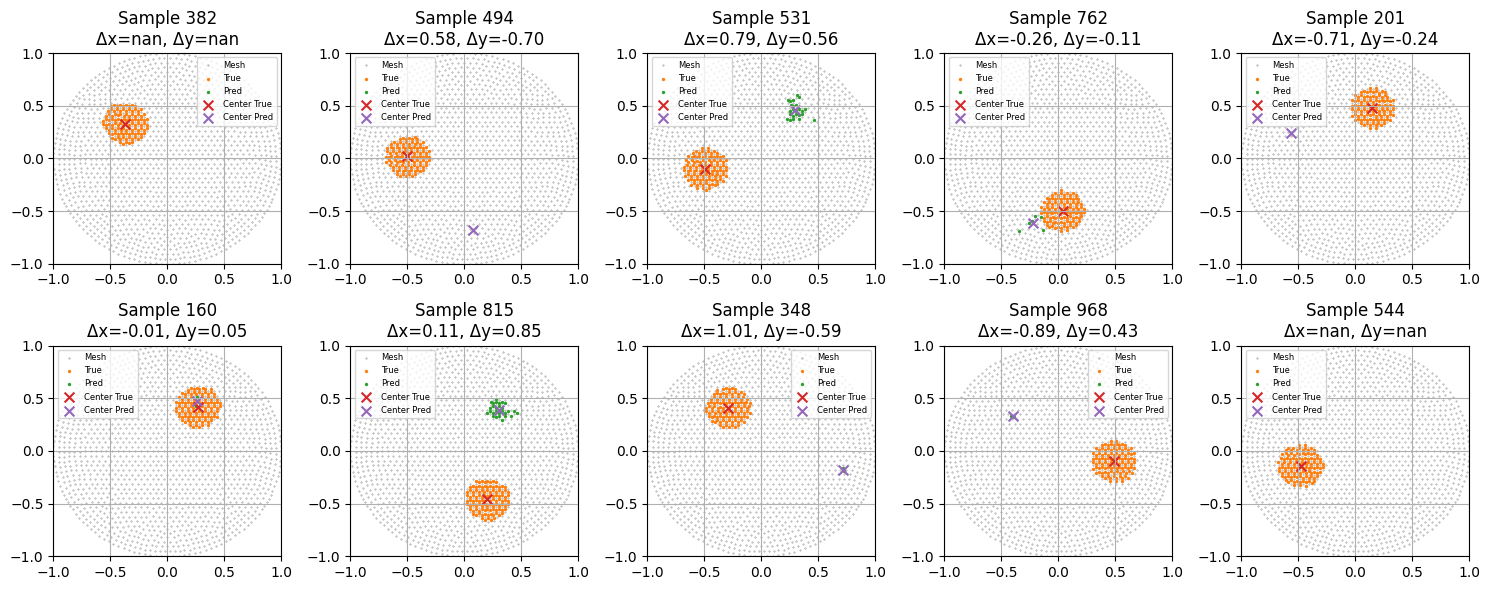

In [38]:
pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)
plot_random_deviations(mesh_obj, gamma_test, gamma_pred, num_samples=10, threshhold=0.5)